In [ ]:
import pandas as pd
import os

from toolz.functoolz import pipe
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import xgboost as xgb


df = pd.DataFrame()
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")

In [1]:
%run -i "preprocess_nolang.ipynb"
%run -i "preprocess_lang.ipynb"
%run -i "evaluation.ipynb"

In [21]:
df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

params = [remove_punctuation, lowercase, tokenize, apply_stemming]


df = pipe(df, *params)


df["utt"] = df["utt"].apply(lambda x: " ".join(x))
df, encoder = encode_labels(df)

print(f"Finished preprocessing dataset.\n\n")

Finished preprocessing dataset.




In [23]:
vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df["utt"].to_list())

In [24]:
input_cols = [
    f"__{feature_name}" for feature_name in vectorizer.get_feature_names_out()
]
output_cols = ["intent"]
averages = [None, "macro", "weighted", "micro", "samples"]

In [25]:
count_vect_df = pd.DataFrame(vectorized.todense(), columns=input_cols)
df = pd.concat([df, count_vect_df], axis=1)

In [26]:
training_df = df[df["partition"] != "test"]
testing_df = df[df["partition"] == "test"]

In [27]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [28]:
training_inputs = vectorizer.transform(training_df["utt"].values)
testing_inputs = vectorizer.transform(testing_df["utt"].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [29]:
english_indices = testing_df.index[(testing_df["locale"] == "en")].values

indices = {
    "en": english_indices,
}

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for MultinomialNB: {'model__alpha': 0.5}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.6997935402618228
Classification report
              precision    recall  f1-score   support

           0     0.8333    0.7353    0.7812        34
           1     0.9333    0.6667    0.7778        21
           2     0.8095    0.8293    0.8193        41
           3     1.0000    0.5455    0.7059        11
           4     0.9474    0.5625    0.7059        32
           5     1.0000    0.0000    0.0000         6
           6     0.4706    0.6154    0.5333        13
           7     0.6250    0.7937    0.6993       126
           8     0.8630    0.9403    0.9000        67
           9     0.7539    0.9234    0.8301       209
          11     0.9365    0.8194    0.8741        72
          12     1.0000    0.3333    0.5000        15
          13     0.7353    0.8523    0.7895        88
          14     0.8000    0.3333    0.4706        12
          

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


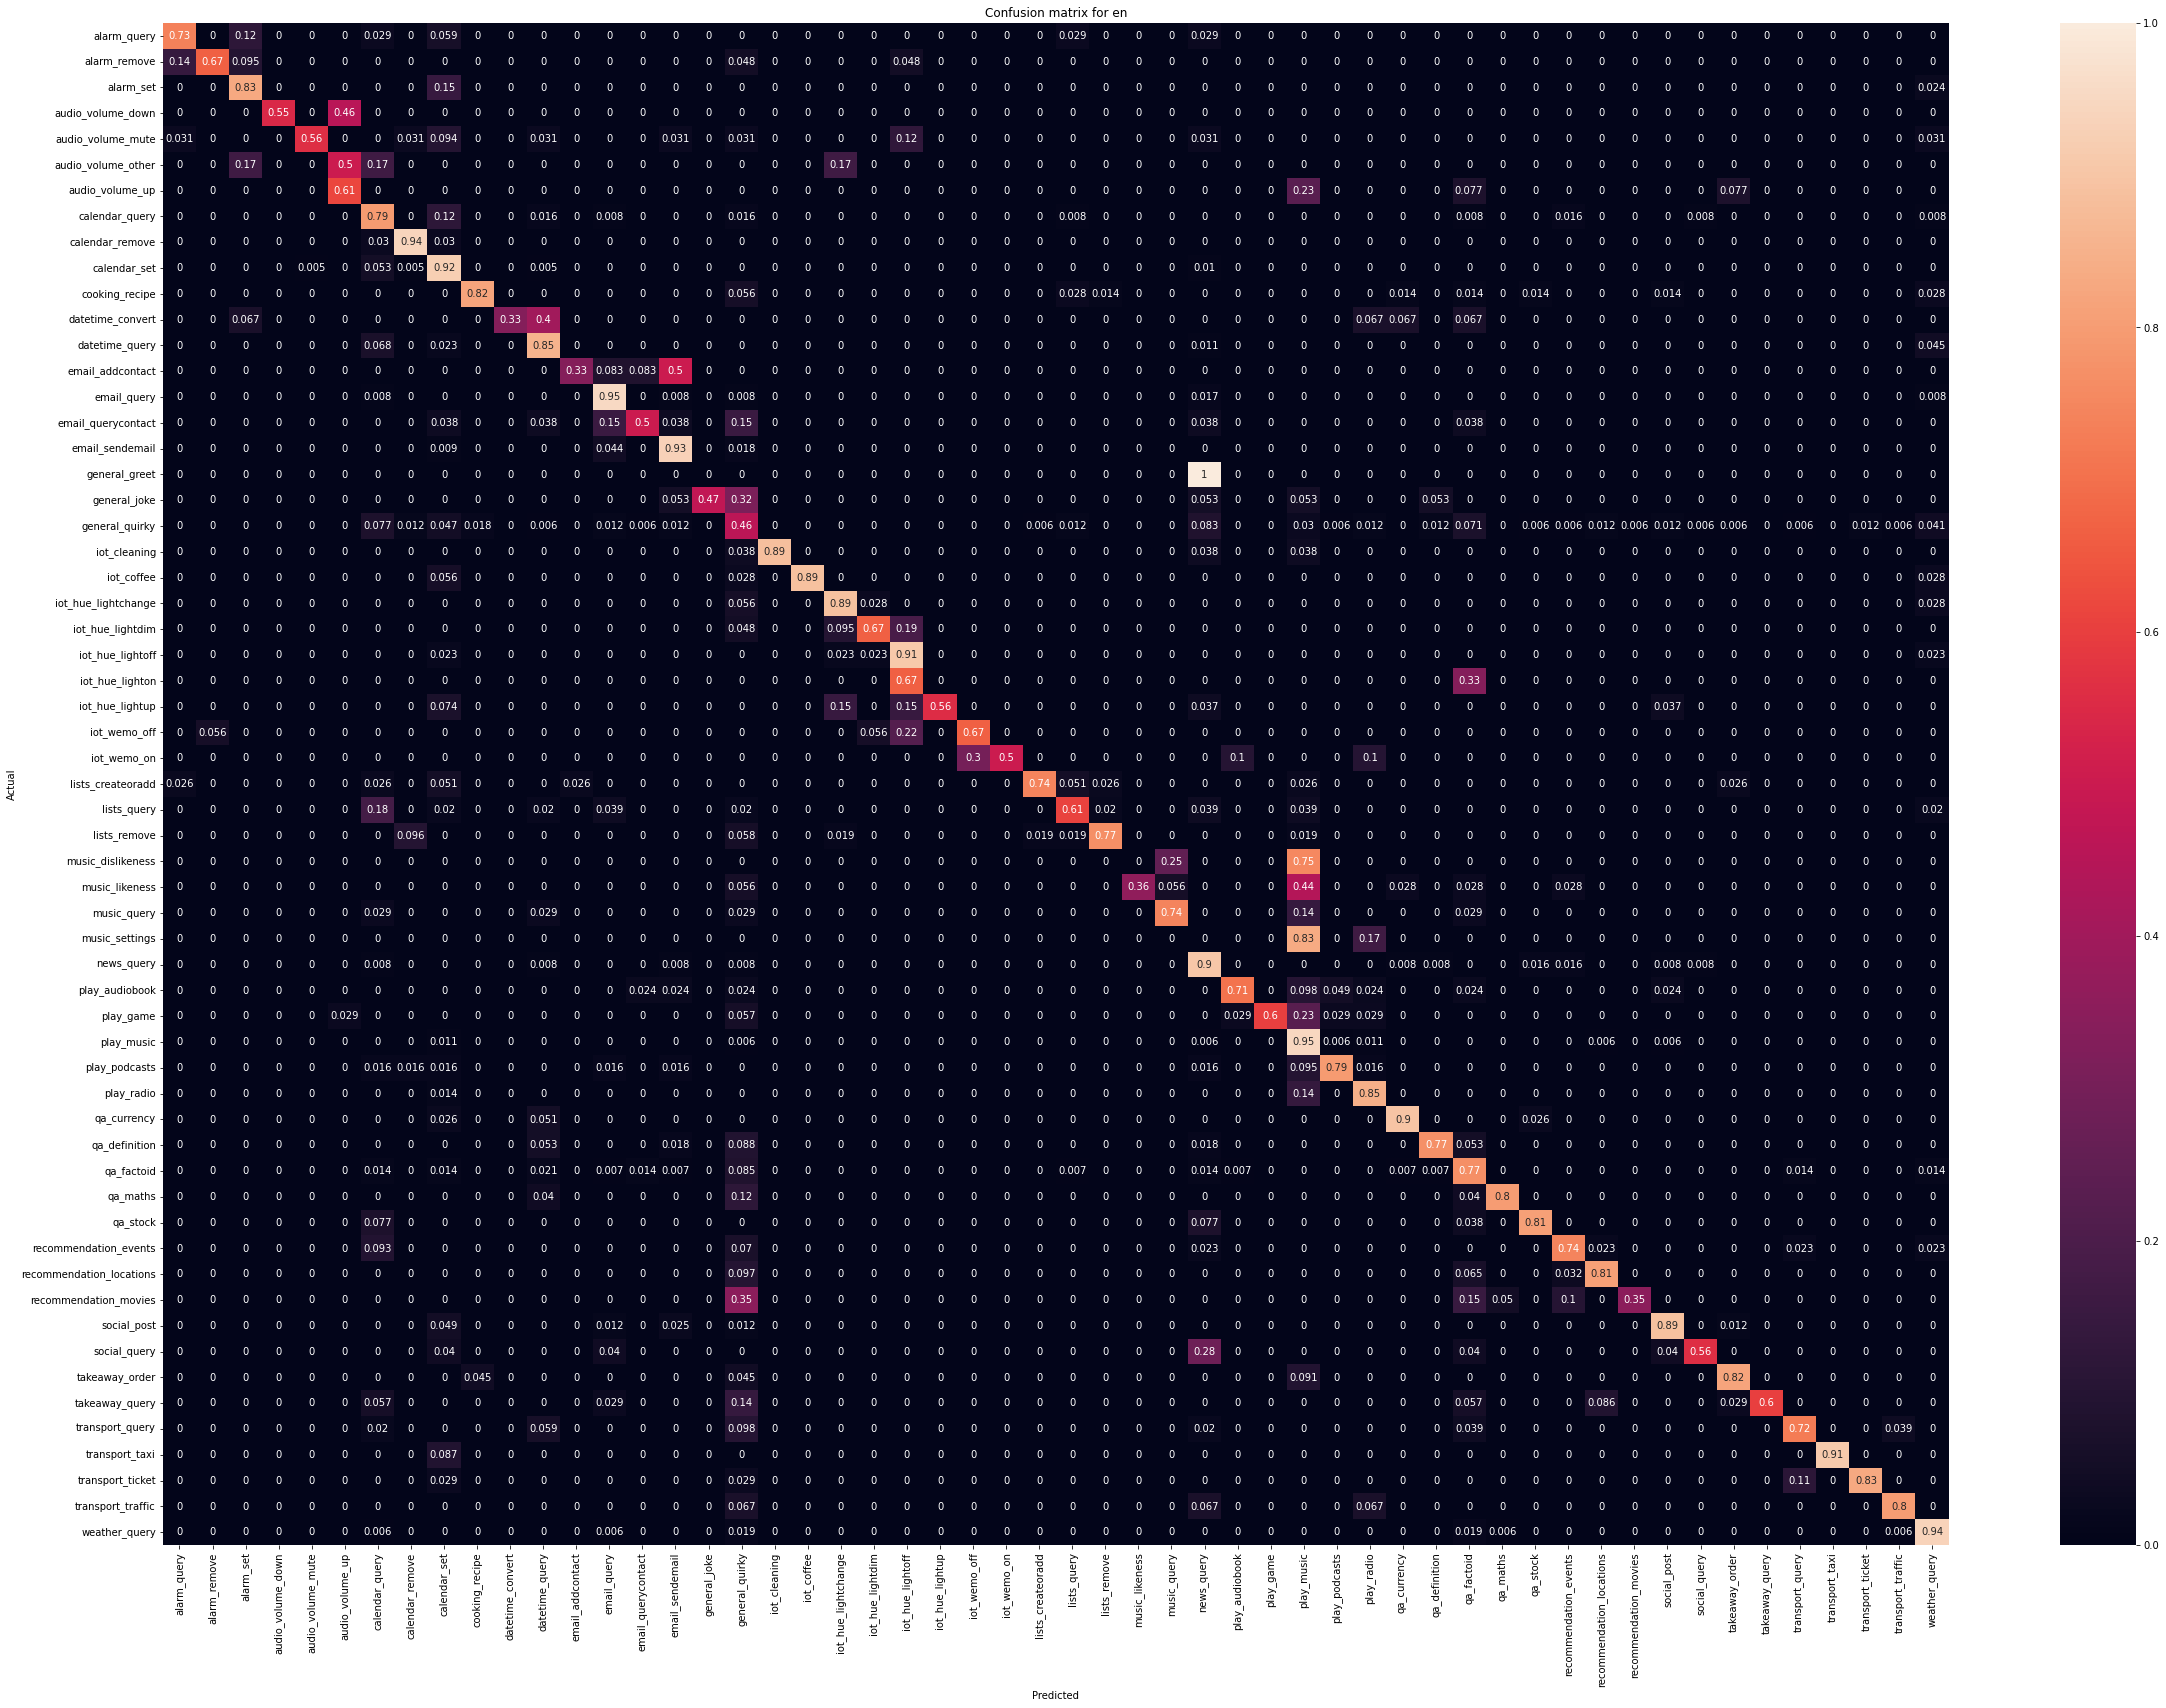

In [ ]:
nb = train_and_use_model(
    MultinomialNB(),
    {
        "model__alpha": [0.1, 0.5, 1.0, 1.5, 2.0],
    },
    n_iter=1,
    indices=indices,
    encoder=encoder,
)

# MultinomialNB

Best params:
{
'model\_\_alpha': 0.1
}


In [ ]:
xgboost = train_and_use_model(
    xgb.XGBClassifier(),
    {
        "model__n_estimators": [100, 200, 300, 400, 500],
        "model__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "model__booster": ["gbtree", "gblinear", "dart"],
        "model__gamma": [0, 0.25, 0.5, 1.0],
        "model__min_child_weight": [1, 3, 5, 7],
        "model__max_delta_step": [0, 0.2, 0.6, 1.0],
        "model__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
    n_iter=3,
)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\

[04:44:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.

Best params for XGBClassifier: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__max_delta_step': 1.0, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__booster': 'gblinear'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.7887292811188353
Classification report
              precision    recall  f1-score   support

           0     0.9032    0.8235    0.8615        34
           1     0.9474    0.8571    0.9000        21
           2     0.7907    0.8293    0.8095        41
           3     0.8182    0.8182    0.8182        11
           4     0.8333    0.9375    0.8824        32
           5     1.0000    0.3333    0.50

# XGBoost

Best Params:
{
'model**subsample': 0.7,
'model**n_estimators': 200,
'model**min_child_weight': 3,
'model**max_depth': 3,
'model**max_delta_step': 1.0,
'model**learning_rate': 0.05,
'model**gamma': 0.5,
'model**booster': 'gblinear'
}


In [30]:
sgd = train_and_use_model(
    SGDClassifier,
    {
        "model__loss": [
            "hinge",
            "log",
            "modified_huber",
            "squared_hinge",
            "perceptron",
        ],
        "model__penalty": ["l2", "l1", "elasticnet"],
        "model__alpha": [0.0001, 0.001, 0.01, 0.1, 1.0],
        "model__l1_ratio": [0.15, 0.3, 0.45, 0.6, 0.75, 0.9],
    },
    n_iter=1,
)

# Logistic Regression

Best Params:
{
'model**penalty': 0.7,
'model**solver': 200,
'model**C': 3,
'model**max_iter': 3,
'model\_\_class_weight': 1.0
}
